In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil, floor
from datetime import datetime 
torch.manual_seed(123)
from tqdm import tqdm
import numpy as np
import random
from torchvision.utils import draw_bounding_boxes
import itertools

### Model 1 - CNN with one fc layer at the end

In [75]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

class CNN_1(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 15): #out_channel [p, x, y, w, h, c_0, ..., c_10] = 15
        super().__init__()
        # image dimension: 48x60

        self.conv1 = nn.Conv2d(in_channels, 4, kernel_size=3, stride=1, padding=1) #size: 48x60
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1) #size: 48x60
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #size: 24x30
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1) #size: 24x30
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) #size: 24x30
        # max_pool, size: 12x15
        self.conv5 = nn.Conv2d(32, 16, kernel_size=(3,2), stride=1, padding=1) #size: 12x16
        # max_pool, size: 6x8
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1) #size: 6x8
        # max_pool, size: 3x4
        self.conv7 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1) #size: 3x4

        # fully connected layer at the end ?
        self.fc = nn.Linear(4*3*4, out_channels) #48x15

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv5(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv6(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv7(out)
        out = F.relu(out)

        out = out.view(-1, out.shape[-3]*out.shape[-2]*out.shape[-1]) #flatten the dimensions to fit the fully connected layer
        out = self.fc(out)
        return out

Training on device cpu.


### Model 2 - Only convolutional layers 

In [76]:
class MyConvOnlyCNN(nn.Module):
    def __init__(self):
        super(MyConvOnlyCNN, self).__init__()
        self.features = nn.Sequential(
            # Input: (batch_size, 1, 48, 60)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # -> (batch_size, 32, 48, 60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # -> (batch_size, 32, 24, 30)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> (batch_size, 64, 24, 30)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # -> (batch_size, 64, 12, 15)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # -> (batch_size, 128, 12, 15)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)         # -> (batch_size, 128, 6, 7)
        )
        
        # Final convolution with a kernel that spans the entire spatial size (6x7)
        # This produces an output of shape (batch_size, 15, 1, 1)
        self.conv_out = nn.Conv2d(128, 15, kernel_size=(6, 7))
    
    def forward(self, x):
        x = self.features(x)
        x = self.conv_out(x)
        x = x.view(x.size(0), -1)  # Flatten to shape (batch_size, 15)
        return x

### Model 3 - Residual network

In [77]:
class ResidualBlock(nn.Module):
    """
    A single residual block with two Conv-BN-ReLU sequences
    and a skip connection: output = ReLU( x + F(x) ).
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        
        padding = kernel_size // 2 # ensures height/witdh remains the same when stride = 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=kernel_size, 
                               stride=1, 
                               padding=padding, 
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # needed if input and output have different shapes 
        # applying a 1 x 1 convolution reshapes the input to the correct dimension
        self.shortcut = nn.Sequential()
        if (stride != 1) or (in_channels != out_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                          kernel_size=1, 
                          stride=stride, 
                          bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # saves original input x
        identity = x 

        # First convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Second convolution
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Applies the shortcut if needed
        identity = self.shortcut(identity)
        
        # Add skip connection
        out += identity
        out = F.relu(out)
        
        return out

class SimpleResNet(nn.Module):
    def __init__(self, out_channels=15):
        """
        ResNet-like model that ends with a final output of dimension 15.
        """
        super().__init__()

        # Stage 1: 1 -> 4 -> 8 channels, then pool
        self.block1 = ResidualBlock(1, 4)
        self.block2 = ResidualBlock(4, 8)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 48×60 -> 24×30

        # Stage 2: 8 -> 16 -> 32, then pool
        self.block3 = ResidualBlock(8, 16)
        self.block4 = ResidualBlock(16, 32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 24×30 -> 12×15

        # Stage 3: conv (3,2) from 32 -> 16, then pool
        # (replicates conv5 in your original network)
        self.conv5 = nn.Conv2d(32, 16, kernel_size=(3,2), 
                               stride=1, padding=(1,1), 
                               bias=False)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 12×?? -> 6×8

        # Stage 4: 16 -> 8, then pool
        self.block5 = ResidualBlock(16, 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 6×8 -> 3×4

        # Final block: 8 -> 4
        self.block6 = ResidualBlock(8, 4)

        # FC: flatten from [batch_size, 4, 3, 4] -> 48, then output 15
        self.fc = nn.Linear(4 * 3 * 4, out_channels)

    def forward(self, x):
        # Stage 1
        out = self.block1(x)
        out = self.block2(out)
        out = self.pool1(out)

        # Stage 2
        out = self.block3(out)
        out = self.block4(out)
        out = self.pool2(out)

        # Stage 3
        out = self.conv5(out)
        out = F.relu(out)
        out = self.pool3(out)

        # Stage 4
        out = self.block5(out)
        out = self.pool4(out)

        # Final block
        out = self.block6(out)

        # Flatten to [batch_size, 48], then FC -> 15
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Localization loss function


In [78]:
def localization_loss(y_pred, y_true):
    """
    Calculates the detection loss, localization loss and classification loss.
    Returns a total loss
    """
    # Detection loss
    L_A = nn.BCEWithLogitsLoss()
    # Bounding box loss (localization loss)
    L_B = nn.MSELoss()
    # Classification loss
    L_C = nn.CrossEntropyLoss()

    # er dette nødvendig egentlig ?? Se om crossentropy loss regnes riktig uten å endre på y_true
    # change format of y_true from [p, x, y, w, h, c] to [p, x, y, w, h, c_1, ..., c_10]
    #c = y_true[:, 5].long()  # get the class index
    #y_true_one_hot = torch.zeros(y_true.size(0), 10, device=y_true.device)  # create a zero tensor for one-hot encoding, device = device ?
    #y_true_one_hot.scatter_(1, c.unsqueeze(1), 1)  # set the corresponding class index to 1
    #y_true = torch.cat([y_true[:, :5], y_true_one_hot], dim=1)  # concatenate the one-hot encoded classes with the rest of y_true

    
    return torch.where(
        # if there is an object; calculate input
        condition=y_true[:, 0].bool(), 

        # L = L_A + L_B + L_C, when object is detected
        input= L_A(y_pred[:, :1], y_true[:, :1]) + 
        L_B(y_pred[:, 1:5], y_true[:, 1:5]) + 
        L_C(y_pred[:, 5:], y_true[:, 5].long()),

        # L = L_A, when object is not detected
        other= L_A(y_pred[:, :1], y_true[:, :1])
    ).mean()




### Load data and preprocessing

/var/folders/6t/376dzz3552sbcyyx1b7h7yfm0000gn/T/ipykernel_16299/1951912206.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_train = torch.load(path + "train.pt")
/v

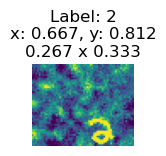

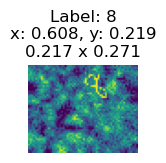

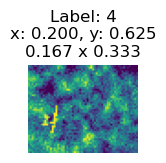

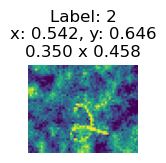

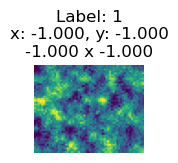

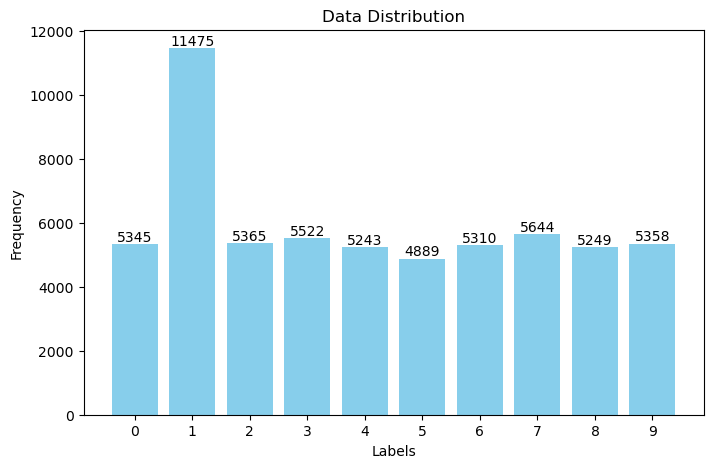

{0.0: 5345,
 1.0: 11475,
 2.0: 5365,
 3.0: 5522,
 4.0: 5243,
 5.0: 4889,
 6.0: 5310,
 7.0: 5644,
 8.0: 5249,
 9.0: 5358}

In [79]:
def load_data(path="data/localization_"):
    """
    Load data from path, return train, val, test
    """
    data_train = torch.load(path + "train.pt")
    data_val = torch.load(path + "val.pt")
    data_test = torch.load(path + "test.pt")


    return data_train, data_val, data_test


def data_distribution(data):
    """
    Plots the distribution of the given data across the labels with labels and counts.
    """
    
    labels = [label[5] for _, label in data]  # Assuming label[5] contains the class label
    
    # Calculate distribution using numpy
    unique_labels, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique_labels, counts))
    
    x_labels = [str(int(label)) for label in unique_labels]  # Convert to string for plotting
    
    # Visualize the label distribution using a bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(x_labels, counts, color='skyblue')
    
    # Add text on top of each bar to display count
    for bar, count, label in zip(bars, counts, x_labels):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"{count}", ha='center', va='bottom', fontsize=10)

    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Data Distribution')
    plt.show()
    
    return distribution


def visualize_random_images(data, num_images):
    """
    Visualizes random images from the data
    """
    indices = random.sample(range(len(data)), num_images)
    samples = [data[i] for i in indices]
    # Set up the figure
    plt.figure(figsize=(6, 4))
    
    # Loop over the selected samples
    for i, (img, label) in enumerate(samples):
        digit = int(label[5])
        x, y, w, h = label[1], label[2], label[3], label[4]
        

        plt.subplot(1, num_images, i+1)
        
        # If the image is a tensor, convert it to a numpy array for plotting.
        if torch.is_tensor(img):
            # Convert from (C, H, W) to (H, W, C)
            img = img.permute(1, 2, 0).numpy()
            
        plt.imshow(img)
        title_str = f"Label: {digit}\nx: {x:.3f}, y: {y:.3f}\n{w:.3f} x {h:.3f}"
        plt.title(title_str)
        plt.axis('off')
    
        plt.tight_layout()
        plt.show()

train_data, val_data, test_data = load_data()

visualize_random_images(train_data, 5)
data_distribution(train_data)

### Normalize Images

In [80]:

def mean_std(data):
    """
    Calculate the mean and standard deviation of the data.
    """
    img, _ = data.tensors
    img = img.float()
    mean = img.mean(dim=(0, 2, 3))
    std = img.std(dim=(0, 2, 3))

    return mean, std


# Lasse sin kode
class LocalizationDataset(Dataset):
    def __init__(self, data, preprocessor=None):
        self.data = data
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        
        if self.preprocessor:
            image = self.preprocessor(image)
            
        return image, label
    
mean, std = mean_std(train_data)
print(f"Mean: {mean}")
print(f"Std: {std}")

preprocessor = transforms.Compose([
        transforms.Normalize(mean, std)
])

# preprocesses data
train_data = LocalizationDataset(train_data, preprocessor = preprocessor)
val_data = LocalizationDataset(val_data, preprocessor = preprocessor)
test_data = LocalizationDataset(test_data, preprocessor = preprocessor)


Mean: tensor([0.4171])
Std: tensor([0.2138])


### Training

In [81]:
def train(n_epochs, optimizer, model, loss_func, train_loader):

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs}", leave=False):

            # We use torch.double to get the same results as Pytorch
            imgs = imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device, dtype=torch.double)

            outputs = model(imgs)
            
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)
        
        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
        
    return losses_train 

In [51]:
#model = CNN_1(in_channels=1).to(device=device, dtype=torch.double)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
loss_func = localization_loss

#train(1, optimizer, model, loss_func, train_loader)

### Visualizing Predictions

In [82]:
# Lasse sin kode:

def unnormalize(image, mean, std):
    return image * std + mean

def convert_box(box, H, W):
    # Convert normalized [x, y, w, h] (center format) to [x_min, y_min, x_max, y_max] in pixel coordinates
    x, y, w, h = box
    x_min = (x - w / 2) * W
    y_min = (y - h / 2) * H
    x_max = (x + w / 2) * W
    y_max = (y + h / 2) * H
    return torch.tensor([x_min, y_min, x_max, y_max], device=box.device)


def visualize_predictions(model, image, label, preprocessor=None, mean=[0.0], std=[1.0], detection_threshold=0.5):
    model.eval()
    device = next(model.parameters()).device

    image_proc = preprocessor(image) if preprocessor else image.clone()
    image_proc = image_proc.unsqueeze(0).to(device, dtype = torch.double)

    with torch.no_grad():
        outputs = model(image_proc)

    pred = outputs[0]
    pred_pc = torch.sigmoid(pred[0]).item()
    pred_box = pred[1:5]
    pred_class = torch.argmax(pred[5:]).item()

    gt_pc = label[0].item()
    gt_box = label[1:5]
    gt_class = int(label[5].item())

    image_disp = unnormalize(image, mean, std)
    image_disp = (image_disp.clamp(0, 1) * 255).to(torch.uint8)
    if image_disp.shape[0] == 1:
        image_disp = image_disp.repeat(3, 1, 1)
    _, H, W = image_disp.shape

    pred_box_pixels = convert_box(pred_box, H, W)
    gt_box_pixels = convert_box(gt_box, H, W)

    # Prepare lists for boxes, colors, and labels for drawing both predicted and ground truth boxes
    boxes = []
    colors = []
    
    if pred_pc > detection_threshold:
        boxes.append(pred_box_pixels)
        colors.append("red")
    
    if gt_pc > 0.5:
        boxes.append(gt_box_pixels)
        colors.append("green")
        
    if boxes:
        boxes = torch.stack(boxes)
        image_with_boxes = draw_bounding_boxes(image_disp, boxes, colors=colors, width=1)
    else:
        image_with_boxes = image_disp

    image_np = image_with_boxes.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.axis("off")
    plt.title("Prediction vs Ground Truth")
    # Create a caption with prediction details and ground truth info
    caption = (f"Prediction: Class {pred_class} (Prob: {pred_pc:.2f}) | "
               f"Ground Truth: Class {gt_class}")
    # Place caption below the image
    plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

### Model selection and evaluation

In [83]:
def _change_coordinates(bb):
    """
    Change bb from [x, y, w, h] to [x1, y1, x2, y2] (topleft and downright corners)
    """
    x1 = bb[0] - bb[2]/2 # midt - bredde
    y1 = bb[1] - bb[3]/2 # midt - høyde

    x2 = bb[0] + bb[2]/2 # midt + bredde
    y2 = bb[1] + bb[3]/2 # midt + høyde

    return [x1, y1, x2, y2]


In [84]:
def intersection(bb1, bb2):
    """
    Compute intersection between 2 bb, in global frame of ref
    """
 
    # Change bb from [x, y, w, h] to [x1, y1, x2, y2] (topleft and downright corners)
    b1 = _change_coordinates(bb1)
    b2 = _change_coordinates(bb2)

    # når man har formen [x1, y1, x2, y2]:
    xA = max(b1[0], b2[0]) # finner største x verdi for topleft corner
    yA = max(b1[1], b2[1]) # finner største y verdi for topleft corner
    # (xA, yA) er topleft av intersection 
    
    xB = min(b1[2], b2[2]) # finner minste x verdi for downright corner
    yB = min(b1[3], b2[3]) # finner minste y verdi for downright corner
    # (xB, yB) er downright av intersection 

    area = max(xB-xA, 0) * max(yB-yA, 0)
    return area

   
def IoU(bb1, bb2):
    """
    Compute IoU given 2 bb (local or global)
    """
    intersect = intersection(bb1, bb2)
    union = bb1[-1]*bb1[-2] + bb2[-1]*bb2[-2] - intersect
    IoU = intersect / union
    return IoU
   

# Lasse sin
def compute_IoU_localization(model, loader, preprocessor):
    """
    Compute IoU performance of the model on the given dataset
    """
    model.eval()
    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device, dtype=torch.double)
            labels = labels.to(device, dtype=torch.double)

            outputs = model(images)

            mask = (labels[:, 0] == 1)
            if mask.sum() == 0:
                continue

            pred_boxes = outputs[mask, 1:5]
            true_boxes = labels[mask, 1:5]

            batch_iou = []
            for i in range(len(true_boxes)):
                iou_value = IoU(pred_boxes[i], true_boxes[i])
                batch_iou.append(iou_value)
            
            total_iou += sum(batch_iou)
            num_samples += len(images)
            
    return total_iou/num_samples
    
   #TODO


# Lasse sin
def compute_accuracy_localization(model, loader, preprocessor):
    """
    Compute accuracy of the model on the given dataset
    """
    model.eval()
    num_correct = 0
    num_samples = 0
        
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device,dtype=torch.double)
            labels = labels.to(device, dtype=torch.double)

            outputs = model(images)
            mask = (labels[:, 0] == 1)
            if mask.sum() == 0:
                continue
            class_probs = torch.softmax(outputs[mask, 5:], dim=1)
            class_pred = torch.argmax(class_probs, dim=1)
            class_true = labels[mask, 5].long()

            num_correct += (class_pred == class_true).sum().item()
            num_samples += mask.sum().item()
    
    return num_correct/num_samples
    

# from performance avsnitt:
""" 
To evaluate how well the model can classify and draw bounding boxes, overall performance can be defined as the mean of the accuracy and the IoU.
The total number of images to classify is the total number of images containing an object (i.e., when the first element pc of y true is 1).
The number of correctly classified images is the number of predictions where both the predicted pc and the predicted label matches their counterparts in y true
"""

def overall_performance(model, loader, preprocessor):
    """
    Compute the overall performance of the model on the given dataset"
    """
    accuracy = compute_accuracy_localization(model, loader, preprocessor)
    IoU = compute_IoU_localization(model, loader, preprocessor)

    print(f"Val Accuracy: {accuracy:.4f}")
    print(f"Val Mean IoU: {IoU:.4f}")
    
    return (accuracy + IoU) / 2

In [ ]:
# testing stuff
#val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
#model.eval()

#performance = overall_performance(model, val_loader, preprocessor)
#print(f"Overall performance: {performance:.4f}")

# Sample usage:
#sample_image, sample_label = val_data[7]
#visualize_predictions(model, sample_image, sample_label, preprocessor, mean, std) #mean=[mean.item()], std=[std.item()])

Val Accuracy: 0.1005
Val Mean IoU: 0.0008
Overall performance: 0.0507


ValueError: Boxes need to be in (xmin, ymin, xmax, ymax) format. Use torchvision.ops.box_convert to convert them

## Model selection and evaluation

In [85]:


# Standard hyperparameters for architecture selection
default_lr = 0.001
default_weight_decay = 0.01
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# List of model classes to test
models = [SimpleResNet, CNN_1, MyConvOnlyCNN]  # You can add more models here, e.g., [MyCNN, MyConvOnlyCNN]

# Phase 1: Architecture Selection with default hyperparameters
best_model_arch = None
best_arch_score = -float('inf')
all_losses = {}

for model_class in models:
    print(f"Training {model_class.__name__} with default hyperparameters (lr={default_lr}, weight_decay={default_weight_decay})")
    # Instantiate the model
    model = model_class()
    model = model_class().to(device=device, dtype=torch.double)

    
    # Create an optimizer using default hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=default_lr, weight_decay=default_weight_decay)
    
    # Train the model (for a fixed number of epochs, e.g., 1 for quick comparison)
    losses = train(
        n_epochs=30,
        optimizer=optimizer,
        model=model,
        loss_func=loss_func,
        train_loader=train_loader
    )
    
    # Stores the losses 
    all_losses[model_class.__name__] = losses
    
    # Evaluate the model on the validation set
    performance = overall_performance(model, val_loader, preprocessor)
    print(f"Performance for {model_class.__name__}: {performance:.4f}")
    
    # Keep track of the best performing architecture
    if performance > best_arch_score:
        best_arch_score = performance
        best_model_arch = model_class

print("Best model architecture:", best_model_arch.__name__)


Training SimpleResNet with default hyperparameters (lr=0.001, weight_decay=0.01)


20:19:53.085690  |  Epoch 1  |  Training loss 1.54622


20:21:32.833752  |  Epoch 2  |  Training loss 0.51111


20:23:09.615768  |  Epoch 3  |  Training loss 0.31970


20:24:47.482215  |  Epoch 4  |  Training loss 0.26776


20:26:25.662107  |  Epoch 5  |  Training loss 0.24413


20:28:06.780010  |  Epoch 6  |  Training loss 0.22772


20:29:49.736510  |  Epoch 7  |  Training loss 0.21568


20:31:28.908383  |  Epoch 8  |  Training loss 0.21078


20:33:08.021788  |  Epoch 9  |  Training loss 0.20323


20:34:46.674669  |  Epoch 10  |  Training loss 0.19926


20:36:25.878994  |  Epoch 11  |  Training loss 0.19692


20:38:03.712035  |  Epoch 12  |  Training loss 0.19039


20:39:42.085351  |  Epoch 13  |  Training loss 0.18674


20:41:21.652980  |  Epoch 14  |  Training loss 0.18689


20:43:01.548601  |  Epoch 15  |  Training loss 0.18177


20:44:40.194100  |  Epoch 16  |  Training loss 0.18405


20:46:19.158519  |  Epoch 17  |  Training loss 0.17887


20:47:58.329659  |  Epoch 18  |  Training loss 0.18100


20:49:39.631242  |  Epoch 19  |  Training loss 0.17461


20:51:19.396051  |  Epoch 20  |  Training loss 0.17953


20:52:57.978743  |  Epoch 21  |  Training loss 0.17394


20:54:37.537674  |  Epoch 22  |  Training loss 0.17251


20:56:16.167304  |  Epoch 23  |  Training loss 0.17589


20:57:55.296254  |  Epoch 24  |  Training loss 0.17448


20:59:34.281831  |  Epoch 25  |  Training loss 0.17475


21:01:13.577048  |  Epoch 26  |  Training loss 0.17324


21:02:52.149568  |  Epoch 27  |  Training loss 0.17275


21:04:31.685540  |  Epoch 28  |  Training loss 0.17063


21:06:10.648375  |  Epoch 29  |  Training loss 0.17326


21:07:55.772210  |  Epoch 30  |  Training loss 0.17374
Val Accuracy: 0.1003
Val Mean IoU: 0.0501
Performance for SimpleResNet: 0.0752
Training CNN_1 with default hyperparameters (lr=0.001, weight_decay=0.01)


21:08:38.412284  |  Epoch 1  |  Training loss 2.31344


21:09:12.581119  |  Epoch 2  |  Training loss 1.96074


21:09:47.133479  |  Epoch 3  |  Training loss 1.77644


21:10:21.357906  |  Epoch 4  |  Training loss 1.64887


21:10:55.658437  |  Epoch 5  |  Training loss 1.61685


21:11:29.689819  |  Epoch 6  |  Training loss 1.58333


21:12:03.224112  |  Epoch 7  |  Training loss 1.53882


21:12:37.097184  |  Epoch 8  |  Training loss 1.49831


21:13:10.912798  |  Epoch 9  |  Training loss 1.45714


21:13:44.267443  |  Epoch 10  |  Training loss 1.41251


21:14:17.991580  |  Epoch 11  |  Training loss 1.37334


21:14:51.678987  |  Epoch 12  |  Training loss 1.32223


21:15:25.032003  |  Epoch 13  |  Training loss 1.26331


21:15:58.398916  |  Epoch 14  |  Training loss 1.19390


21:16:32.363125  |  Epoch 15  |  Training loss 1.12991


21:17:06.178805  |  Epoch 16  |  Training loss 1.07678


21:17:39.664839  |  Epoch 17  |  Training loss 1.02361


21:18:13.120986  |  Epoch 18  |  Training loss 0.97950


21:18:46.758111  |  Epoch 19  |  Training loss 0.93081


21:19:20.512869  |  Epoch 20  |  Training loss 0.89098


21:19:54.425819  |  Epoch 21  |  Training loss 0.85361


21:20:28.130995  |  Epoch 22  |  Training loss 0.82609


21:21:01.871173  |  Epoch 23  |  Training loss 0.80058


21:21:35.468199  |  Epoch 24  |  Training loss 0.77322


21:22:09.064335  |  Epoch 25  |  Training loss 0.75025


21:22:42.785547  |  Epoch 26  |  Training loss 0.72640


21:23:16.397605  |  Epoch 27  |  Training loss 0.70273


21:23:50.109271  |  Epoch 28  |  Training loss 0.68174


21:24:23.878362  |  Epoch 29  |  Training loss 0.66365


21:24:57.026229  |  Epoch 30  |  Training loss 0.64283
Val Accuracy: 0.1207
Val Mean IoU: 0.0006
Performance for CNN_1: 0.0606
Training MyConvOnlyCNN with default hyperparameters (lr=0.001, weight_decay=0.01)


21:26:28.139935  |  Epoch 1  |  Training loss 1.60992


21:27:55.466183  |  Epoch 2  |  Training loss 0.87930


21:29:20.797575  |  Epoch 3  |  Training loss 0.68156


21:30:48.513494  |  Epoch 4  |  Training loss 0.58646


21:32:15.932177  |  Epoch 5  |  Training loss 0.53643


21:33:41.614595  |  Epoch 6  |  Training loss 0.50626


21:35:07.829639  |  Epoch 7  |  Training loss 0.49192


21:36:34.663951  |  Epoch 8  |  Training loss 0.47850


21:38:03.399978  |  Epoch 9  |  Training loss 0.46883


21:39:31.629904  |  Epoch 10  |  Training loss 0.46072


21:40:58.077410  |  Epoch 11  |  Training loss 0.45634


21:42:25.376457  |  Epoch 12  |  Training loss 0.45151


21:43:51.500527  |  Epoch 13  |  Training loss 0.45066


21:45:17.992634  |  Epoch 14  |  Training loss 0.44744


21:46:44.104917  |  Epoch 15  |  Training loss 0.44385


21:48:11.267668  |  Epoch 16  |  Training loss 0.43840


21:49:38.035348  |  Epoch 17  |  Training loss 0.43937


21:51:04.976325  |  Epoch 18  |  Training loss 0.43427


21:52:31.449079  |  Epoch 19  |  Training loss 0.43627


21:53:57.783596  |  Epoch 20  |  Training loss 0.43802


21:55:24.084927  |  Epoch 21  |  Training loss 0.43283


21:56:50.811452  |  Epoch 22  |  Training loss 0.43294


21:58:16.949806  |  Epoch 23  |  Training loss 0.43221


21:59:43.752762  |  Epoch 24  |  Training loss 0.43216


22:01:10.766466  |  Epoch 25  |  Training loss 0.43128


22:02:36.480760  |  Epoch 26  |  Training loss 0.43225


22:04:02.509763  |  Epoch 27  |  Training loss 0.43111


22:05:28.833990  |  Epoch 28  |  Training loss 0.42622


22:06:55.782395  |  Epoch 29  |  Training loss 0.43077


22:08:22.823424  |  Epoch 30  |  Training loss 0.42855
Val Accuracy: 0.1008
Val Mean IoU: 0.0014
Performance for MyConvOnlyCNN: 0.0511
Best model architecture: SimpleResNet


# Tuning the best performing model

In [43]:

# Define the hyperparameters to search over for tuning
learning_rates = [0.001, 0.0005, 0.0001]
weight_decays = [0, 0.01, 0.001]
# Hyperparameters to add???
# batch size
# optimizer
# momentum 
# IoU threshold


# Phase 2: Hyperparameter Tuning for the best architecture
best_model = None
best_score = -float('inf')
best_hyperparams = {}

for lr, wd in itertools.product(learning_rates, weight_decays):
    print(f"Tuning {best_model_arch.__name__} with lr={lr}, weight_decay={wd}:")
    
    # Instantiate a new model for each hyperparameter combination
    model = best_model_arch()
    model = model_class().to(device=device, dtype=torch.double)

    # Create an optimizer with current hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # Train the model on the training data
    losses = train(
        n_epochs=1,
        optimizer=optimizer,
        model=model,
        loss_func=loss_func,
        train_loader=train_loader
    )
    
    # Evaluate the model on the validation data
    performance = overall_performance(model, val_loader, preprocessor)
    print(f"Overall performance: {performance:.4f}\n")
    
    # Update the best model if performance improves
    if performance > best_score:
        best_score = performance
        best_model = model
        best_hyperparams = {
            'model': best_model_arch.__name__,
            'lr': lr,
            'weight_decay': wd
        }

print("Best hyperparameters:", best_hyperparams)
print("Best overall performance on validation set:", best_score)

# Final Testing on the test set
# Assuming you have a test_loader defined for your test_data
test_overall_performance = overall_performance(best_model, test_loader, preprocessor)
print(f"Test overall performance: {test_overall_performance:.4f}")


Tuning CNN_1 with lr=0.001, weight_decay=0


14:26:52.129260  |  Epoch 1  |  Training loss 2.80421
Val Accuracy: 0.1112
Val Mean IoU: 0.0553
Overall performance: 0.0832

Tuning CNN_1 with lr=0.001, weight_decay=0.01


14:27:22.475294  |  Epoch 1  |  Training loss 2.18559
Val Accuracy: 0.0963
Val Mean IoU: 0.0027
Overall performance: 0.0495

Tuning CNN_1 with lr=0.001, weight_decay=0.001


14:27:54.454268  |  Epoch 1  |  Training loss 2.05090
Val Accuracy: 0.0963
Val Mean IoU: 0.0024
Overall performance: 0.0494

Tuning CNN_1 with lr=0.0005, weight_decay=0


KeyboardInterrupt: 